In [29]:
import os
import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATA = '../'
DATASET = os.path.abspath(DATA) + '/DataDNA Dataset Challenge - April 2023.csv'

In [142]:
df = pd.read_csv(DATASET)

### OUTLIERS

In [143]:
#FUNCTION TO DETECT OUTLIERS USING Z-SCORE METHOD
def zscore_outlier(x,lb,ub):
    zscore = ((x - x.mean()) / x.std()).copy()
    result_ = pd.Series([0] * len(x))
    result_[((zscore < lb) | (zscore > ub))] = 1
    df_outlier=pd.concat({'Value':x, 'Outlier':result_},axis=1)
    outlier_lst = df_outlier[df_outlier['Outlier']==1]['Value'].tolist()
    return result_, outlier_lst

In [144]:
#FUNCTION MARK OUTLIERS FROM DATASET
def mark_outliers(df, colname_lst, val_lst):
    for col in colname_lst:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    col1 = colname_lst[0]
    col2 = colname_lst[1]
    df['Outliers'] = np.where((df[col1].isin(val_lst))|(df[col2].isin(val_lst)), 'YES', 'NO')
    return df

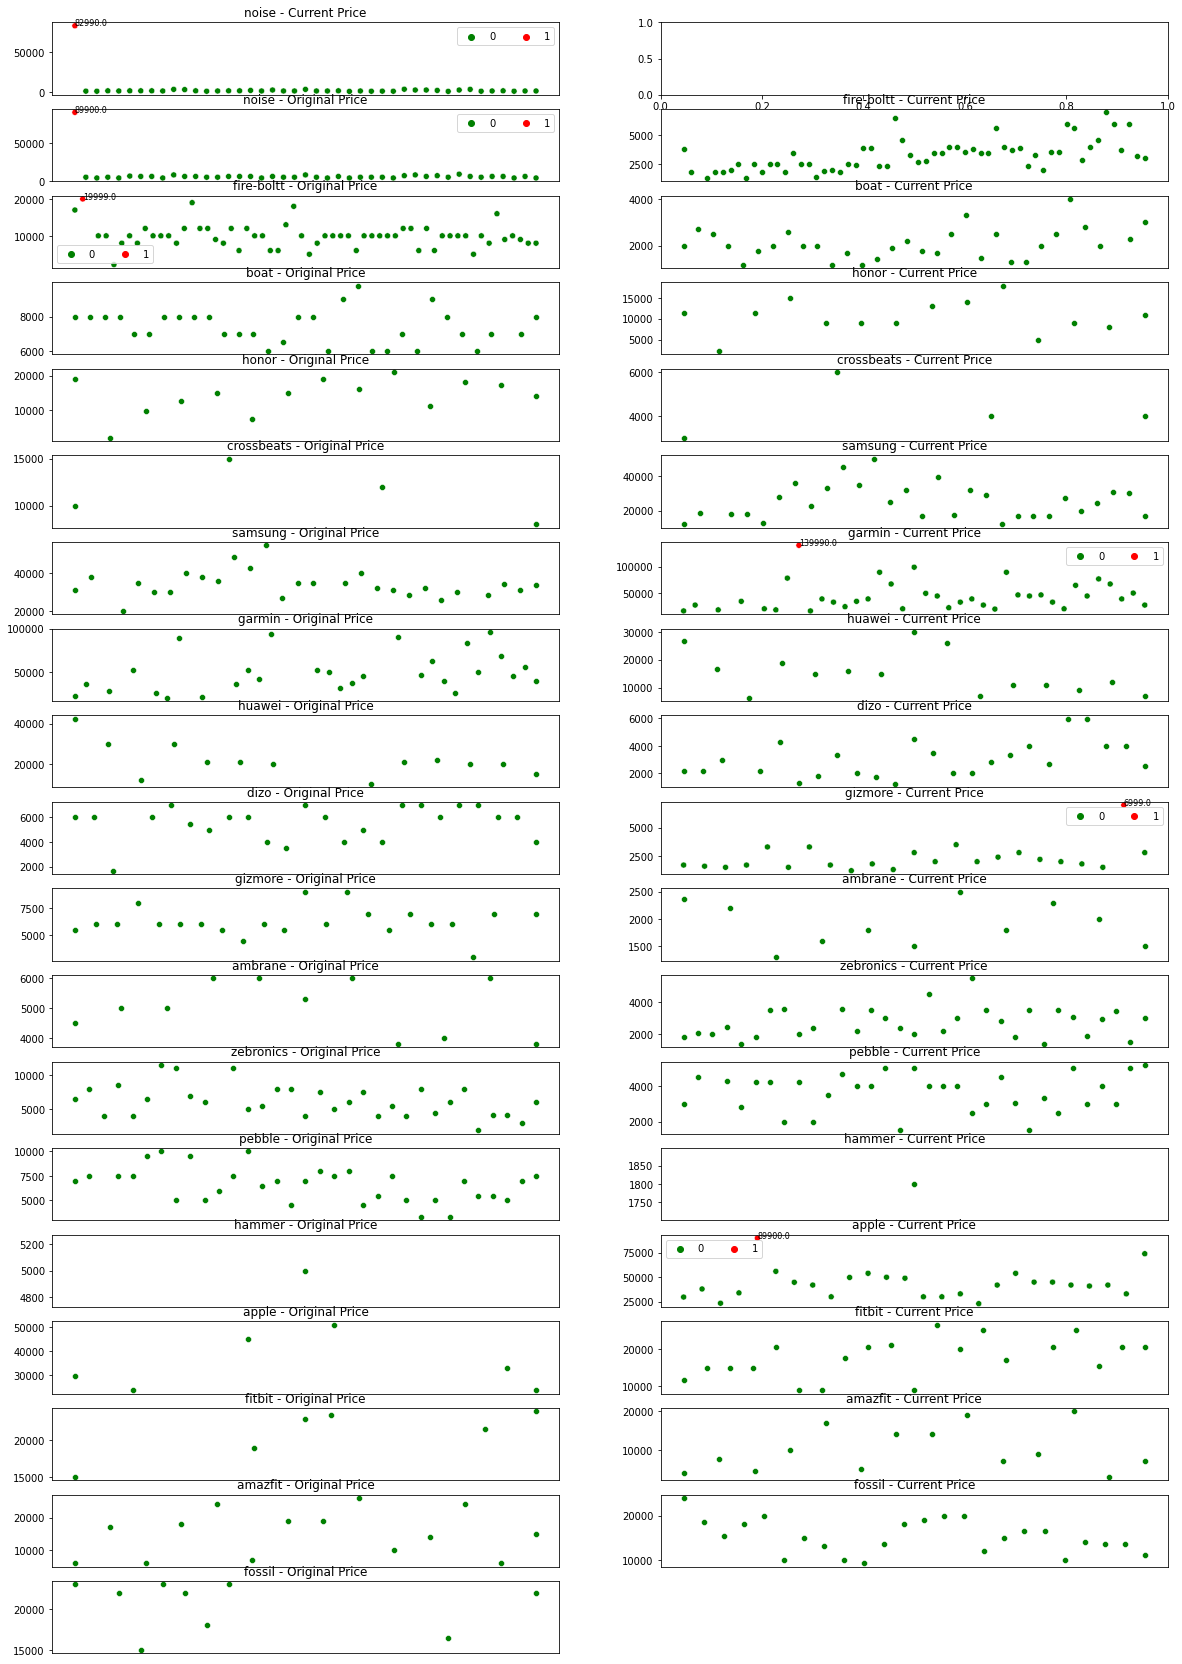

In [145]:
#PLOTTING A SCATTER PLOT AND HIGHLIGHTING THE OUTLIERS DETECTED BY Z-SCORE METHOD
column_to_detect = ['Current Price' , 'Original Price']
lst_brands = df['Brand'].unique().tolist()

fig, ax = plt.subplots(len(lst_brands)+1, 2, figsize=(20, 30))
row = col = 0
new_df = pd.DataFrame()
for brand in lst_brands:
    data = df[df['Brand']==brand].reset_index(drop=True)
    outlier_final_lst = list()
    for n,i in enumerate(column_to_detect):
        if (n > 0):
            row += 1
            col = 0
        
        outliers, outlier_lst = zscore_outlier(data[i], -3, 3)
    
        if sum(outliers) == 0:
            sns.scatterplot(x = np.arange(len(data[i])), y = data[i], ax = ax[row, col], legend=False, color = 'green')
        else:
            sns.scatterplot(x = np.arange(len(data[i])), y = data[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
        for x,y in zip(np.arange(len(data[i]))[outliers == 1], data[i][outliers == 1]):
            ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
        ax[row,col].set_ylabel("")
        ax[row,col].set_title(f'{brand} - {i}')
        ax[row,col].xaxis.set_visible(False)
        if sum(outliers) > 0:
            ax[row,col].legend(ncol=2)
        
        outlier_final_lst.extend(outlier_lst)

        col += 1
    mark_df = mark_outliers(data, colname_lst=column_to_detect, val_lst=outlier_final_lst)
    new_df = new_df.append(mark_df)
ax[row,col].axis('off')

new_df = new_df.loc[:, ~new_df.columns.str.contains('^Unnamed')]
print(new_df.shape)
plt.show()

### PRICE BIN

In [146]:
import jenkspy

In [147]:
df = new_df.copy()
df_price = df[df['Current Price'].notna()]
df_noprice = df[df['Current Price'].isna()]
breaks = jenkspy.jenks_breaks(df_price['Current Price'], n_classes=3)
labels = ['Low', 'Medium', 'High']
df_price['bin_cut_break'] = pd.cut(df_price['Current Price'] , bins=breaks, labels=labels, include_lowest=True)

In [148]:
def rename_label_bin(df, label):
    df = df[df['bin_cut_break']==label]
    min_val = df['Current Price'].min()
    min_val = round(min_val,-3)
    max_val = df['Current Price'].max()
    max_val = round(max_val,-3)
    new_label = f'< {str(int(max_val))}'
    df['Price Range'] = new_label
    return df

In [149]:
new_df = pd.DataFrame()
for label in labels:
    temp = rename_label_bin(df_price, label) 
    new_df = new_df.append(temp)
df = pd.concat([new_df, df_noprice])
print(df.shape)

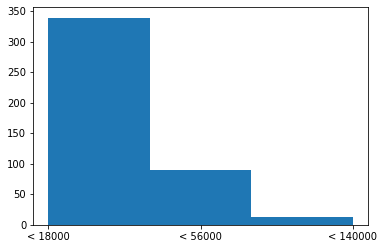

In [150]:
plt.hist(new_df['Price Range'], bins=3)
plt.show()

### FEATURE ENGINEERING

In [ ]:
# One-hot encoding
def yn_encode(text):  
    text=str(text)
    text = text.strip().lower()
    if text=='yes':
        enc=1
    else:
        enc=0
    return enc

In [151]:
pd.options.display.float_format = '{:.2f}'.format   # increase readability
encode_col = ['Brand','Dial Shape', 'Strap Color', 'Strap Material', 'Battery Life (Days)', 'Display Size', 'Weight']
binary_col = ['Bluetooth', 'Touchscreen']
target_col = ['Current Price']
df['INDEX'] = range(1, len(df) + 1)
df_encode = df.dropna(subset=encode_col+binary_col+target_col, how='any')
lst_id = df_encode['INDEX'].tolist()
df_no_encode = df[~df['INDEX'].isin(lst_id)]

encoder=ce.LeaveOneOutEncoder() 

for col in encode_col:
    df_encode[f'{col}_Encode'] = encoder.fit_transform(df_encode[col], df_encode['Current Price'])
    df_encode[f'{col}_Encode'] = df_encode[f'{col}_Encode'].astype(int)


for col in binary_col:
    df_encode[f'{col}_Encode'] =df_encode[col].apply(lambda x:yn_encode(x))

df = pd.concat([df_encode, df_no_encode])
df.to_csv(DATA + f'Cleaned - {os.path.basename(DATASET)}', index=False)
print(df.shape, df.head())

### FEATURE SELECTION

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import RobustScaler

In [96]:
feature_encode_col = [e for e in df.columns if '_Encode' in e]
data = df[['Current Price', 'Rating'] + feature_encode_col]
data = data.dropna()
X = data.drop(['Current Price'], axis=1)
y = data['Current Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape


((141, 11), (98, 10), (43, 10), (98,), (43,))

In [97]:
# Feature Scaling
cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

##### Random Forest

In [99]:
# create the classifier with n_estimators = 100
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
clf.fit(X_train, y_train)

# view the feature scores
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
df_feature = feature_scores.to_frame('Score')
df_feature.to_csv(DATA + 'Feature Scores.csv')
feature_scores

Brand_Encode                  0.157273
Weight_Encode                 0.155455
Strap Material_Encode         0.148527
Dial Shape_Encode             0.143521
Display Size_Encode           0.137883
Strap Color_Encode            0.110532
Rating                        0.084718
Battery Life (Days)_Encode    0.052958
Touchscreen_Encode            0.009134
Bluetooth_Encode              0.000000
dtype: float64

##### XGB Feature Importance

In [43]:
import xgboost

model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_) 

[12:30:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.19006564 0.13951948 0.05958583 0.16551939 0.13956161 0.14201535
 0.16373272 0.         0.        ]


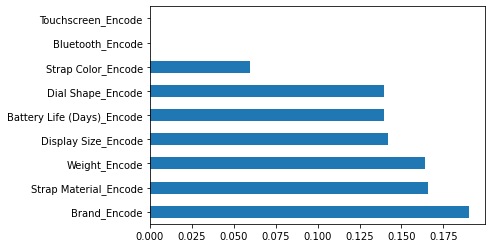

<Figure size 576x432 with 0 Axes>

In [44]:
# plot the graph of feature importances for better visualization 

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')

plt.figure(figsize=(8,6))
plt.show()

### END